In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv("../../store.csv",header=0,index_col=0)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print(df.shape)

df.head()

(2470, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2014-04-10,12937.4,13055.6,12881.2,12949.4,0
2014-04-11,12822.2,12934.9,12778.0,12840.2,0
2014-04-15,12830.5,12831.6,12537.7,12579.9,0
2014-04-16,12557.4,12727.0,12514.8,12563.2,0
2014-04-17,12564.5,12819.1,12514.8,12787.2,0


In [3]:
df_week = df.resample('w').mean()
df_week = df_week[['Close']]
df_week.head()

,Close
Date,
2014-04-13,12894.800000
2014-04-20,12643.433333
2014-04-27,13025.550000
2014-05-04,12922.450000
2014-05-11,13114.560000


In [4]:
# df_week['weekly_ret'] = np.log(df_week['Close']).diff()
df_week['weekly_ret'] = 100*df_week['Close'].pct_change().dropna()
df_week.head()

,Close,weekly_ret
Date,,
2014-04-13,12894.800000,NaN
2014-04-20,12643.433333,-1.949365
2014-04-27,13025.550000,3.022254
2014-05-04,12922.450000,-0.791521
2014-05-11,13114.560000,1.486638


In [5]:
df_week.dropna(inplace=True)

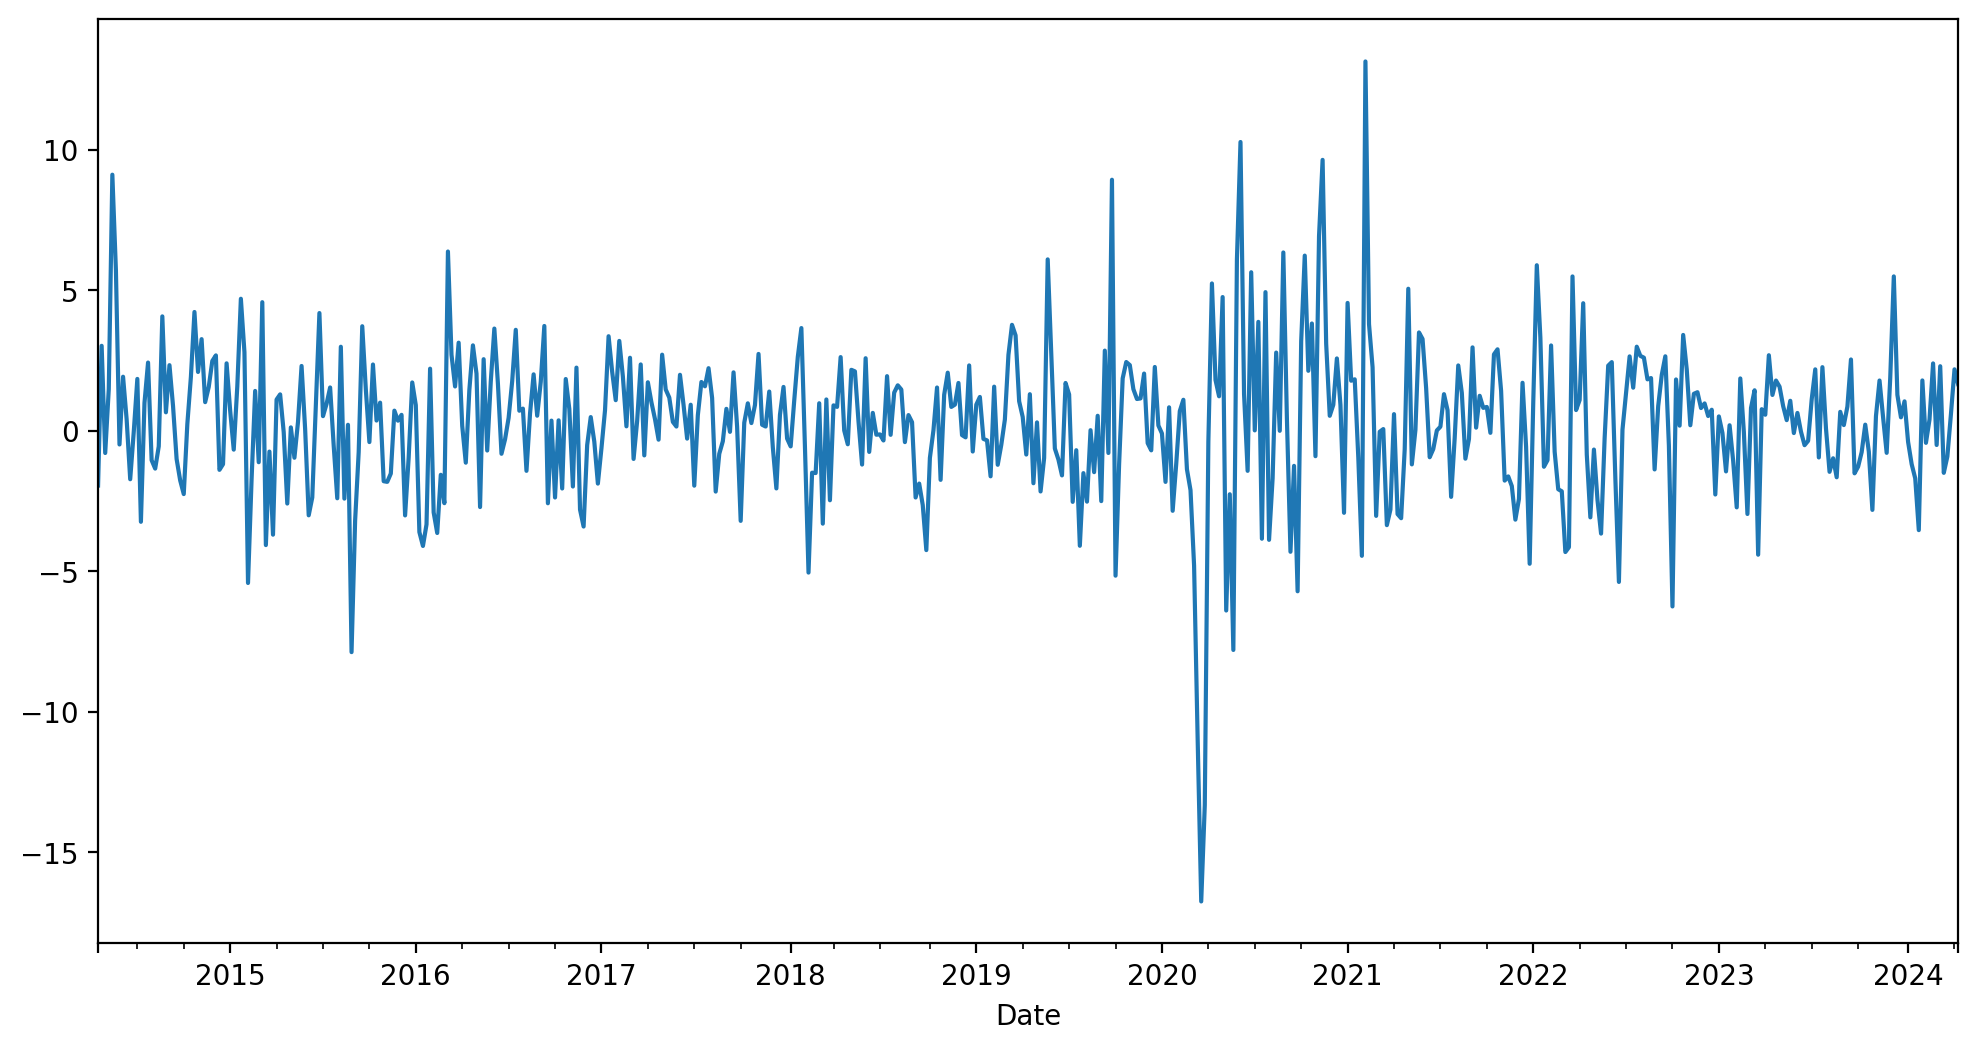

In [6]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

In [7]:
udiff = df_week.drop(['Close'], axis=1)
udiff.head()

,weekly_ret
Date,
2014-04-20,-1.949365
2014-04-27,3.022254
2014-05-04,-0.791521
2014-05-11,1.486638
2014-05-18,9.110942


In [8]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [9]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

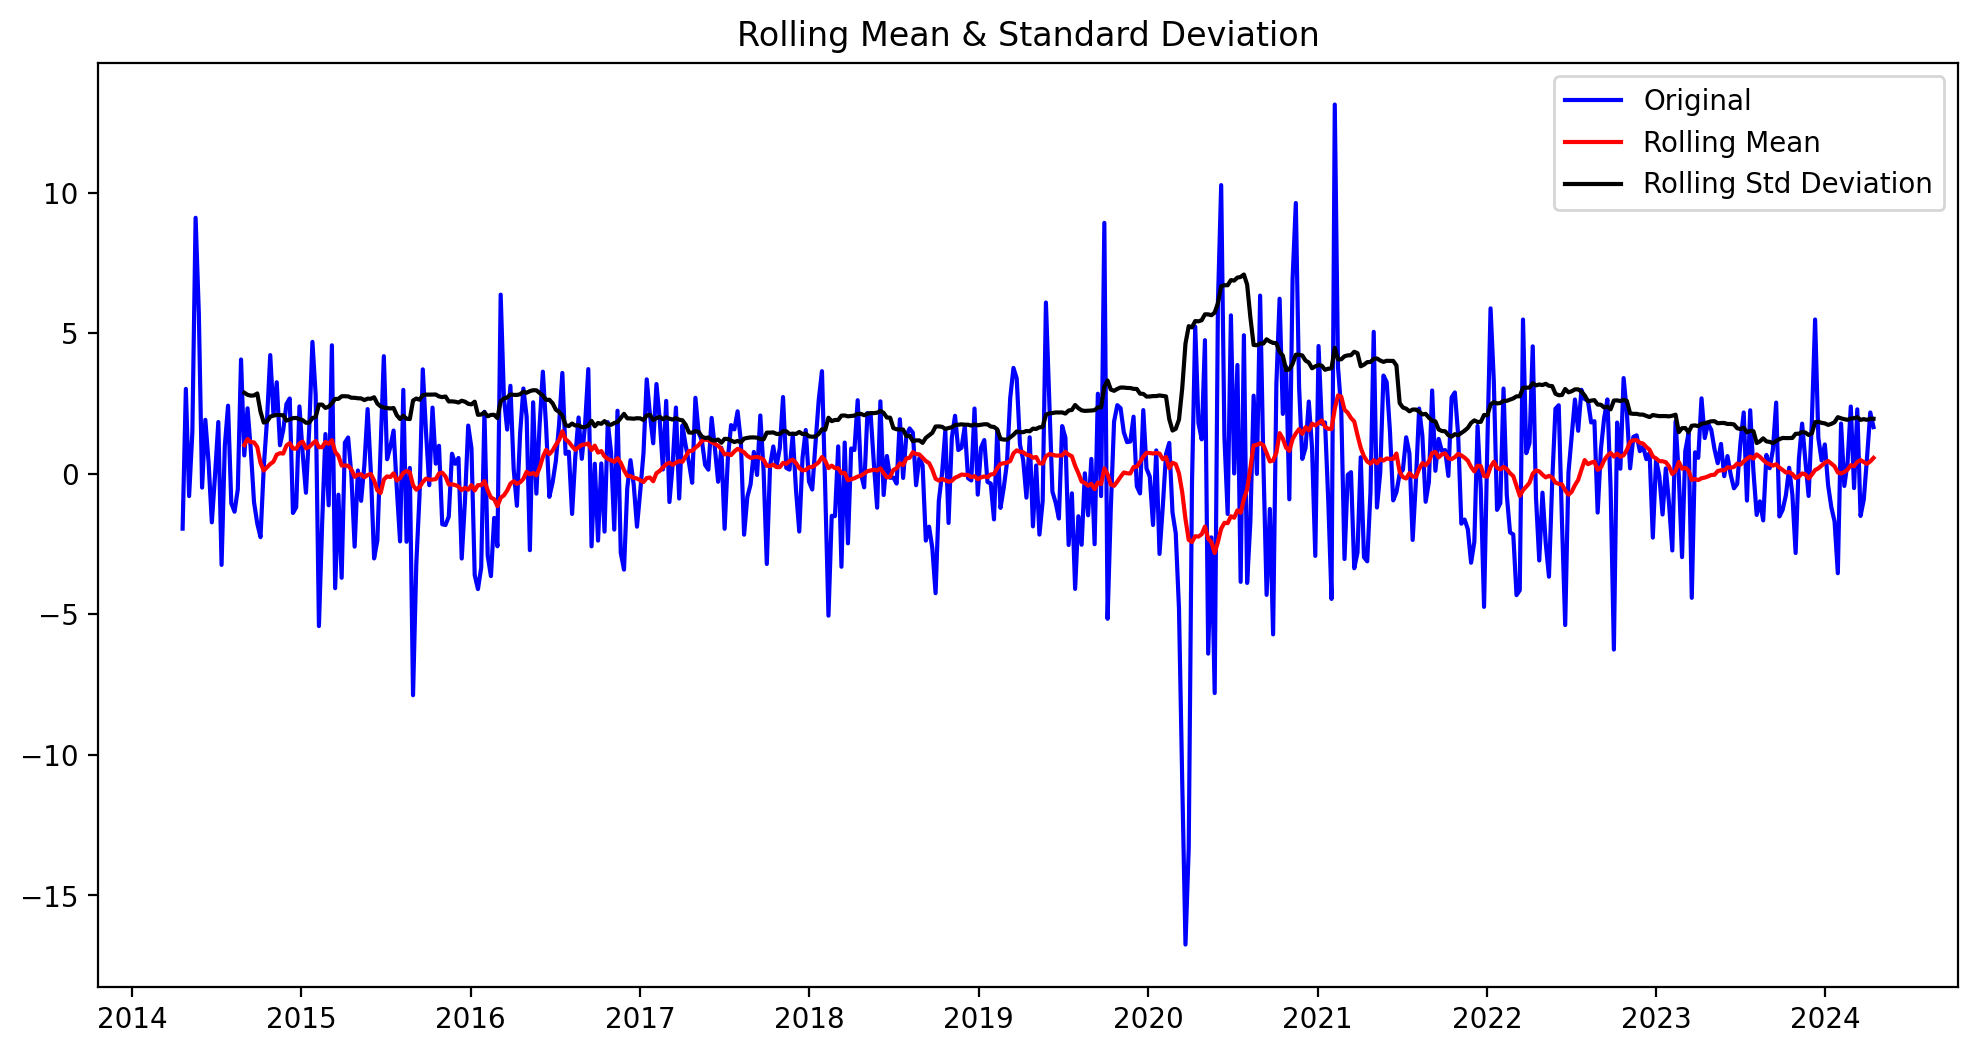

In [10]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [11]:
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.764997e+01
p-value                        3.724172e-30
#Lags Used                     0.000000e+00
Number of Observations Used    5.210000e+02
Critical Value (1%)           -3.442964e+00
Critical Value (5%)           -2.867103e+00
Critical Value (10%)          -2.569733e+00
dtype: float64

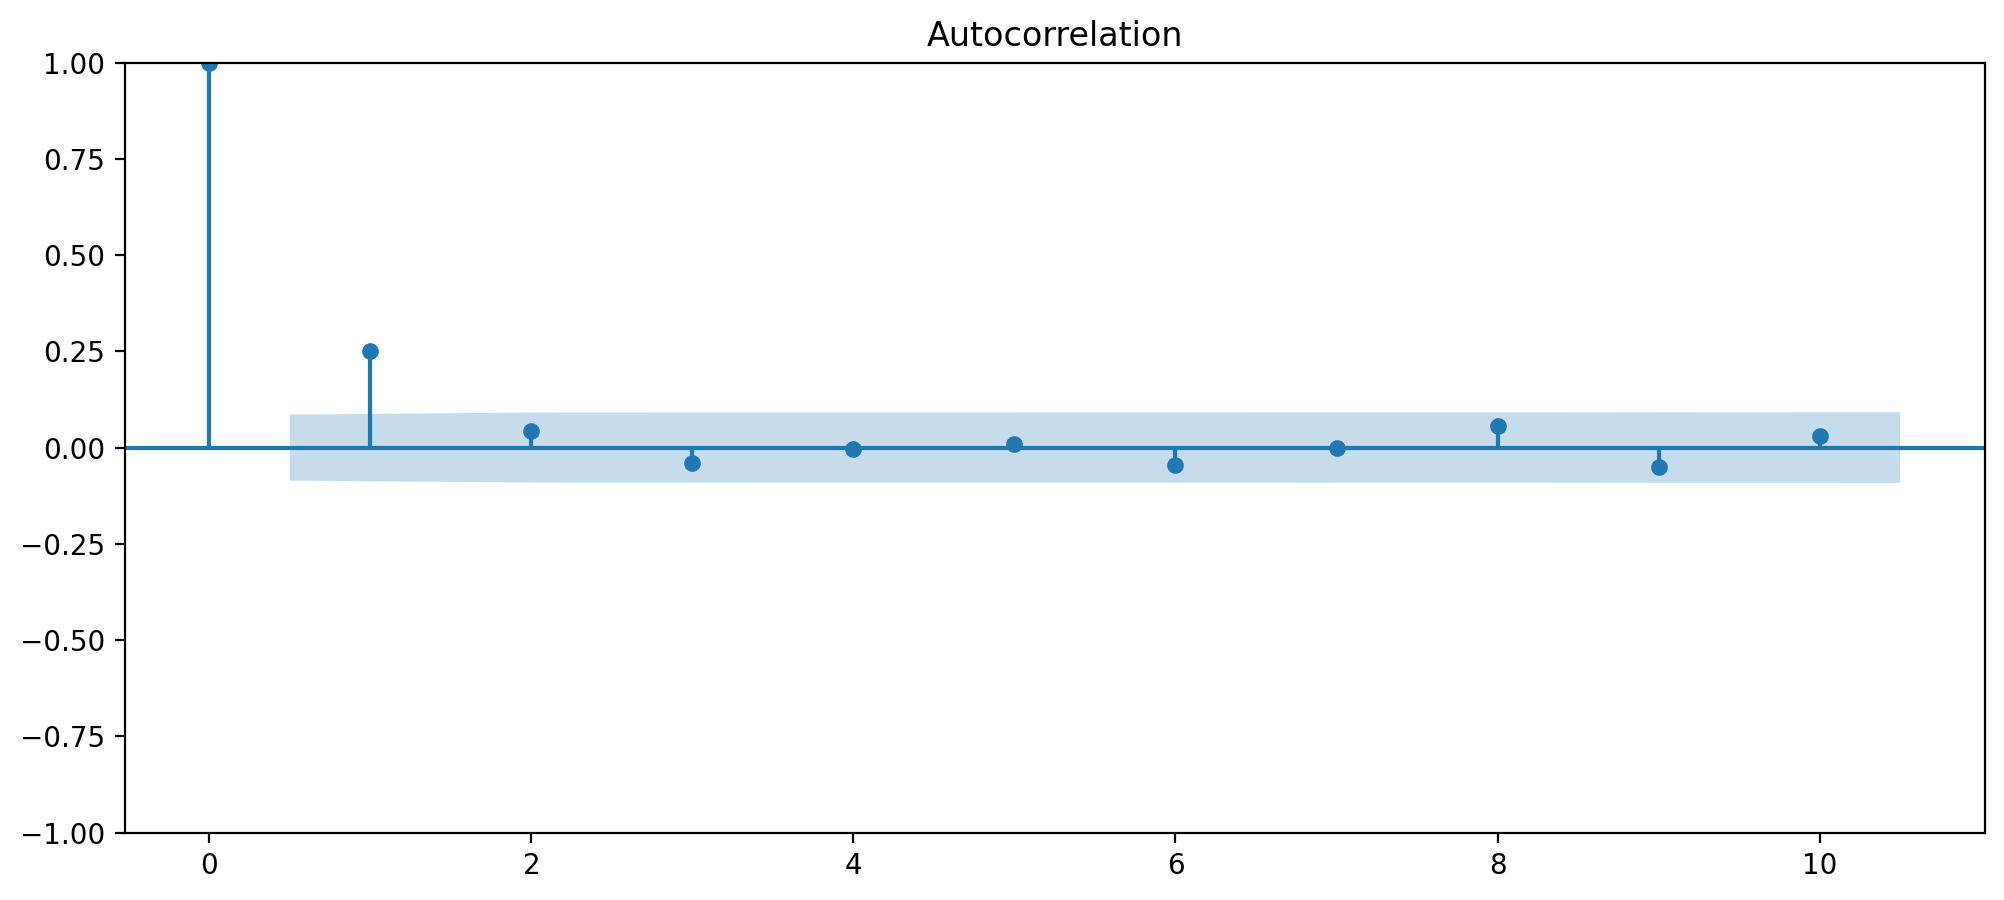

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

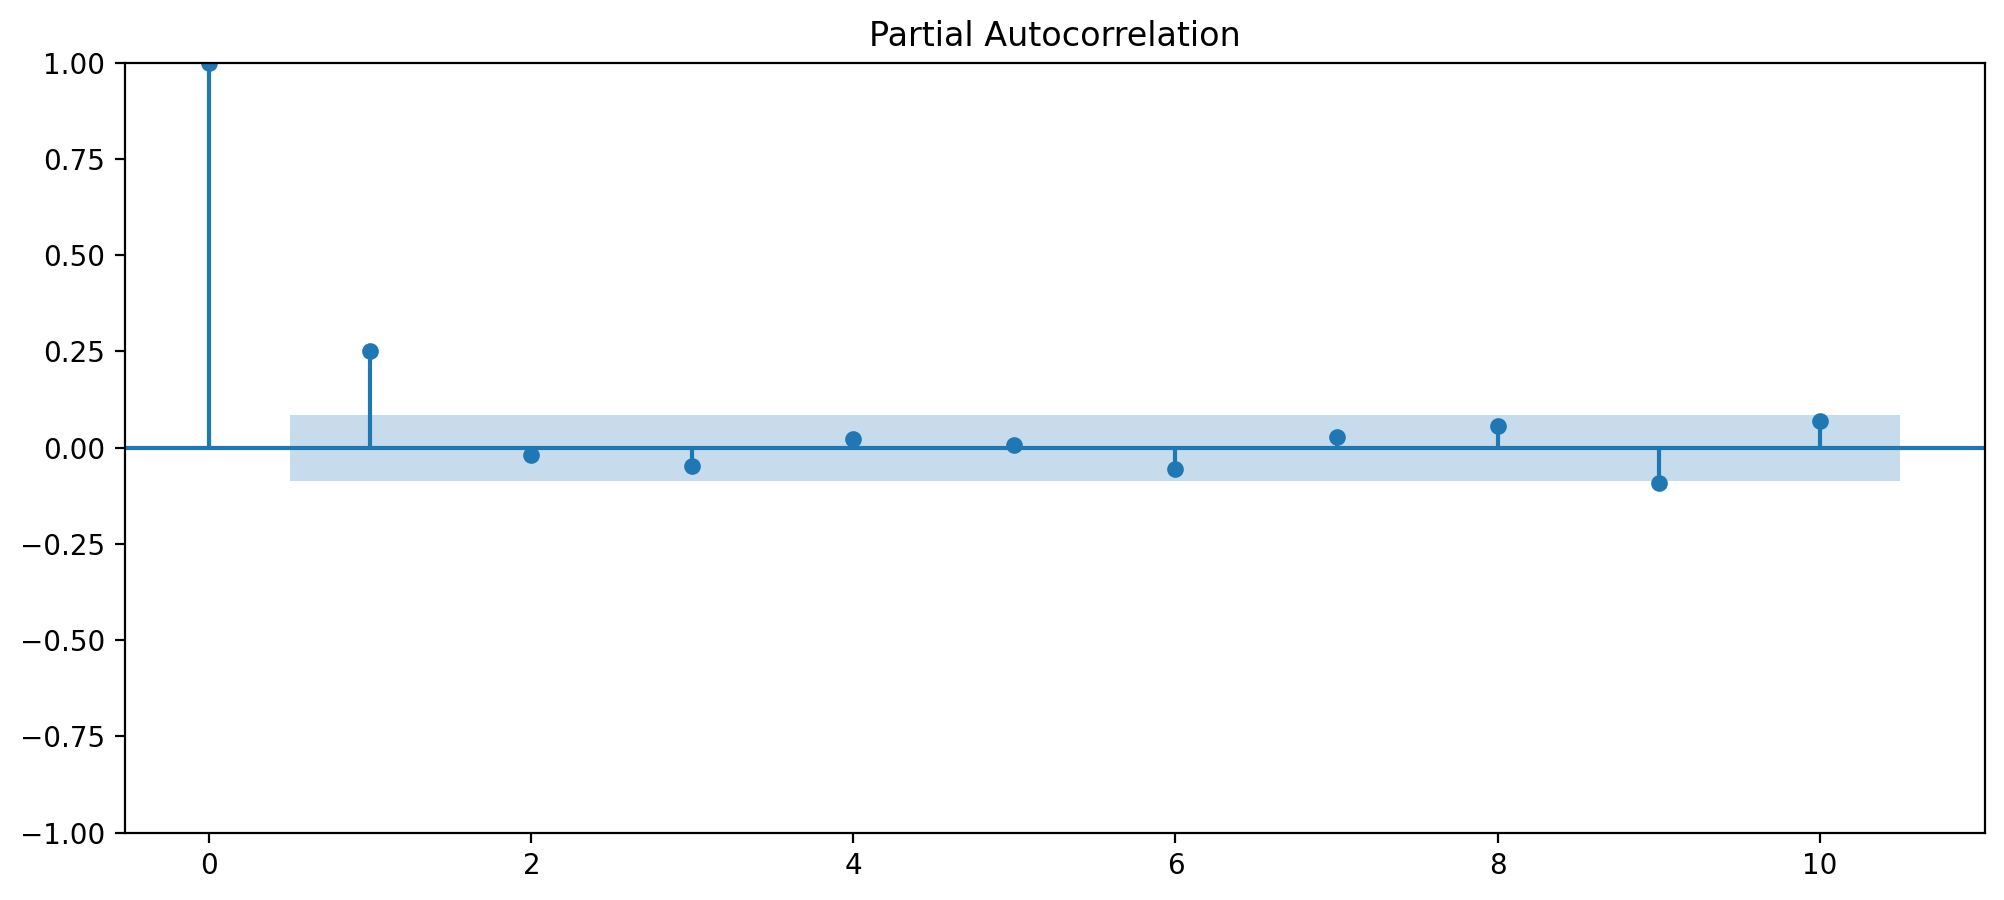

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

In [14]:
from statsmodels.tsa.arima.model import ARIMA
ar1 = ARIMA(udiff.values, order = (1, 0,1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1237.990
Date:                Wed, 01 May 2024   AIC                           2483.980
Time:                        09:51:19   BIC                           2501.011
Sample:                             0   HQIC                          2490.651
                                - 522                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2902      0.161      1.799      0.072      -0.026       0.606
ar.L1          0.1951      0.138      1.416      0.157      -0.075       0.465
ma.L1          0.0589      0.145      0.407      0.684      -0.225       0.343
sigma2         6.7211      0.243     27.634      0.000       6.244       7.198
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               421.33
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.07
Prob(H) (two-sided):                  0.64   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

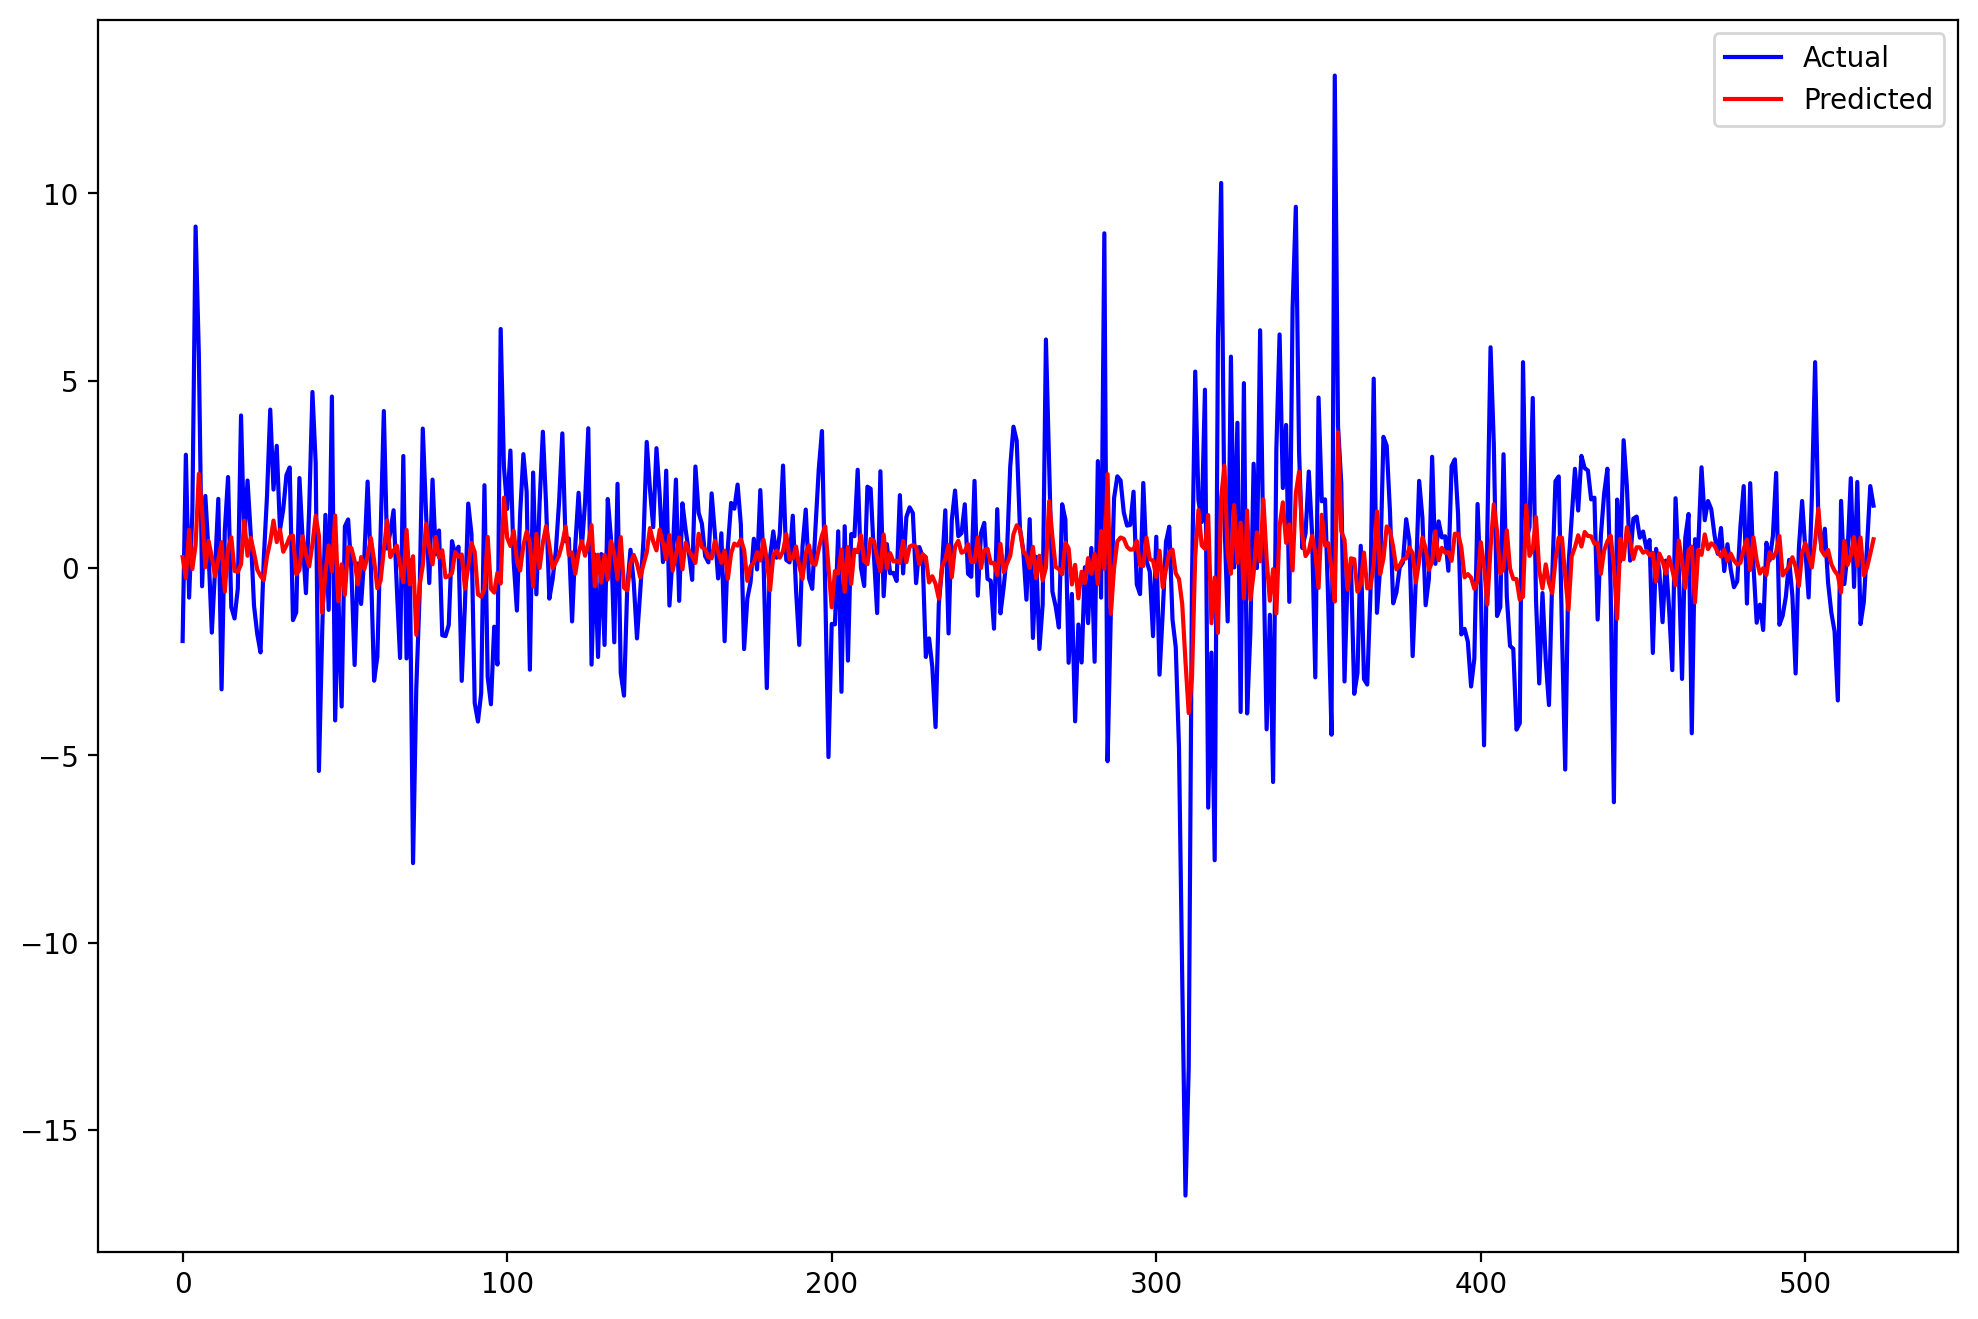

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, label='Actual', color='blue')
preds = ar1.fittedvalues
plt.plot(preds, label='Predicted', color='red',)
plt.legend()
plt.show()